In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [4]:
tf.enable_eager_execution()

In [5]:
#!pip install tensorflow_datasetst
tf.__version__

'1.15.0'

In [6]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [7]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

In [8]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>


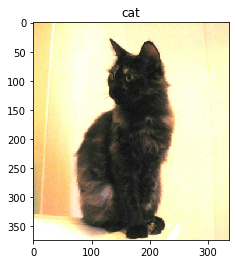

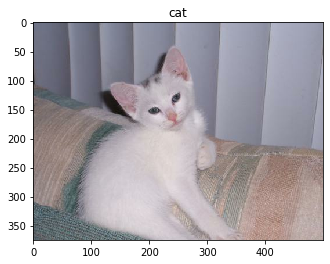

In [9]:
get_label_name = metadata.features['label'].int2str

try:
    
    for image, label in raw_train.take(2):
      plt.figure()
      plt.imshow(image)
      plt.title(get_label_name(label))

except Exception as e: 
    
    print(e)


In [10]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image =tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [11]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [12]:
BATCH_SIZE =32
SHUFFLE_BUFFER_SIZE = 1000

In [27]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [14]:

try:
    for image_batch, label_batch in train_batches.take(1):
        pass
except Exception as e:
    print(e)
    
image_batch.shape

TensorShape([Dimension(32), Dimension(160), Dimension(160), Dimension(3)])

### Creating the base model from pretrained convnets

In [15]:
# base model from MobileNetV2
# contains 1.4 images and 1000 classes
# imagenet is a research training dataset with a wide variety of categories
# like jackfruite and syringe

# first step to pick which layer we would use for feature extraction. 
# The last classification layer is not that useful
# insteadlast layer before flatten is choosen
# this is called the bottleneck layer

# we will first instantiate a mobile net v2 modelpreloaded with weights t
# with inlude_top=False
# which is the ideal for feature extraction

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights = 'imagenet')

9412608/9406464 [==============================] - 211s 22us/step


In [16]:
# feature extractor converts each of 160x160x3 images into
# 5x5x1280 block of features
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [17]:
# freezing the convolutional base before we compile and train
# setting entire model trainable flag = False will freeze all layers

base_model.trainable = False

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [19]:
# to generate predictions from a block of features we 
#averge over the spatial 5x5 locations using a 
# tf.keras.layers.GlobalAveragePooling2D
# to convert the features to a single 1280 vector per image

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [21]:
# apply a tf.keras.layers.Dense layer to convert these features 
# into a singleprediction per image
# you don't need an activation function here because 
# this willl be a logit 

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [22]:
# we will stack these two layer
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [23]:
# compiling the model

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

W0529 11:16:34.812718 14924 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\ops\nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
len(model.trainable_variables)

2

In [28]:
# training the model
initial_epochs =10
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 3s 127ms/step - loss: 0.9726 - acc: 0.3781


In [31]:
print(loss0)
print(accuracy0)

0.9725720673799515
0.378125


In [32]:
# on training batches
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 67s 116ms/step - loss: 0.3960 - acc: 0.7951 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 59s 101ms/step - loss: 0.2066 - acc: 0.9171 - val_loss: 0.1366 - val_acc: 0.9192
Epoch 3/10
582/582 [==============================] - 59s 102ms/step - loss: 0.1688 - acc: 0.9313 - val_loss: 0.1215 - val_acc: 0.9286
Epoch 4/10
582/582 [==============================] - 59s 101ms/step - loss: 0.1520 - acc: 0.9388 - val_loss: 0.1132 - val_acc: 0.9364
Epoch 5/10
582/582 [==============================] - 59s 101ms/step - loss: 0.1420 - acc: 0.9427 - val_loss: 0.1078 - val_acc: 0.9407
Epoch 6/10
582/582 [==============================] - 58s 100ms/step - loss: 0.1353 - acc: 0.9452 - val_loss: 0.1042 - val_acc: 0.9450
Epoch 7/10
582/582 [==============================] - 60s 102ms/step - loss: 0.1304 - acc: 0.9481 - val_loss: 0.1015 - val_acc: 0.9467
Epoch 8/10
582/582 [===========================

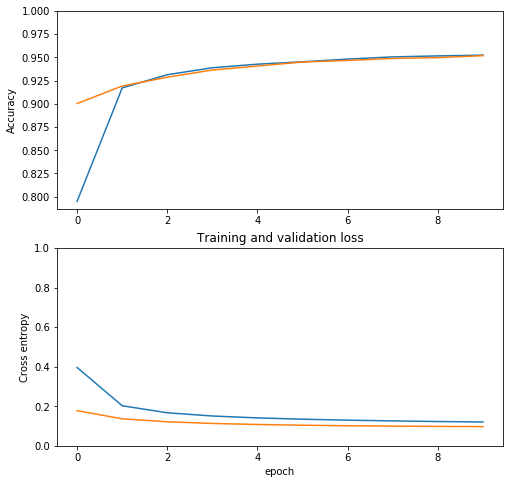

In [35]:
# learning curves
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label="Training accuracy")
plt.plot(val_acc, label="validation accuracy")
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])

plt.subplot(2,1,2)
plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.ylabel('Cross entropy')
plt.ylim([0,1.0])
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.show()

# during training batch normalisation and dropout for regularisation os
# applied  however not in case of validation
# that is why validation metrics are better

In [ ]:
# fine tuning
# we need to fine tune the weights at the top
# this is attempted only after we set the pretrained model tp
# non trainable and trained the model once

# we start by unfreezing the top layers of the model
base_model.trainable = True



In [36]:
# lookina the number of layer
print("The number of layers in teh base model: ", len(base_model.layers))

# finetune from this layeronward
fine_tune_at = 100

# freeze all layer beforefinetune at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

The number of layers in teh base model:  155


In [37]:
# compiling the model

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics = ['accuracy'])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_batches)

Epoch 10/20
582/582 [==============================] - 64s 110ms/step - loss: 0.1159 - acc: 0.9545 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 11/20
582/582 [==============================] - 59s 102ms/step - loss: 0.1161 - acc: 0.9546 - val_loss: 0.0989 - val_acc: 0.9518
Epoch 12/20
582/582 [==============================] - 59s 102ms/step - loss: 0.1159 - acc: 0.9546 - val_loss: 0.0988 - val_acc: 0.9514
Epoch 13/20
582/582 [==============================] - 58s 100ms/step - loss: 0.1157 - acc: 0.9547 - val_loss: 0.0987 - val_acc: 0.9514
Epoch 14/20
582/582 [==============================] - 57s 98ms/step - loss: 0.1155 - acc: 0.9548 - val_loss: 0.0986 - val_acc: 0.9514
Epoch 15/20
582/582 [==============================] - 57s 98ms/step - loss: 0.1154 - acc: 0.9549 - val_loss: 0.0985 - val_acc: 0.9514
Epoch 16/20
582/582 [==============================] - 57s 98ms/step - loss: 0.1152 - acc: 0.9550 - val_loss: 0.0984 - val_acc: 0.9514
Epoch 17/20
582/582 [======================

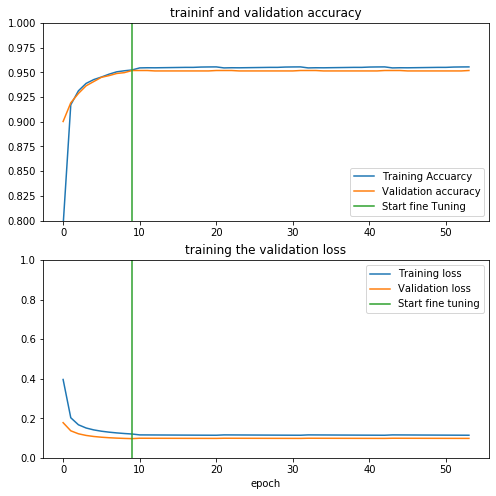

In [46]:
# we again plot the learning curve

acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuarcy')
plt.plot(val_acc, label='Validation accuracy')
plt.ylim([0.8,1])
plt.plot([initial_epochs-1, initial_epochs -1],
         plt.ylim(), label='Start fine Tuning')

plt.legend(loc='lower right')
plt.title('traininf and validation accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start fine tuning')
plt.legend(loc='upper right')
plt.title('training the validation loss')
plt.xlabel('epoch')
plt.show()

### summary:
using a pre trained model feature extraction: when working with a small dataset
it is a common practive ot take advantage of the feature learned by a superior model trained on a large dataset that is publically availabel and then modifiying it for fun and profit.
Fine -tuning is essential somethinf that was not done previosuly in the airforce dataset
another thing to note is the fact tha tthe datset that we woul use need s to 
generaic not just cats and dogs